In [1]:
# !pip install llama-index
# !pip install llama-index-vector-stores-qdrant llama-index-readers-file llama-index-embeddings-fastembed llama-index-llms-openai
# !pip install -U qdrant_client fastembed
# !pip install deepeval -q

In [1]:
import logging
import sys
import os
#from dotenv import load_dotenv
from IPython.display import Markdown, display

# qdrant official client
import qdrant_client

# LLama-index dependencies
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
#from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import Settings

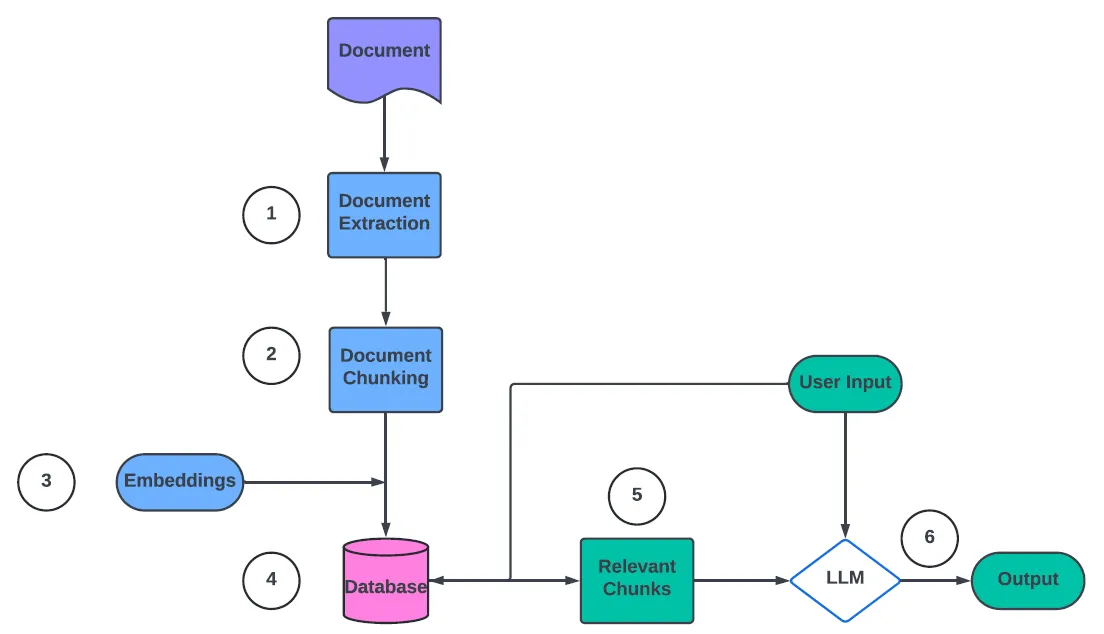

# 4 approaches:
1. Basic RAG using pymupdf for extraction, page chunking, OpenAI embedding and GPT-3.5 LLM
2. Document extraction with intelligent parsing (LlamaParse)
3. RAG with re-ranking
4. Hybrid RAG using embeddings + keywords

# Document Extraction

## Extraction using PyMUPDF

In [ ]:
from llama_index.core.schema import TextNode
from llama_index.core.node_parser import SentenceSplitter
import fitz

file_path = "../data/Q1-2023-Amazon-Earnings-Release.pdf"
doc = fitz.open(file_path) #A
#B
text_parser = SentenceSplitter(
    chunk_size=2048,
)
text_chunks = [] #C
for doc_idx, page in enumerate(doc):
    page_text = page.get_text("text")
    cur_text_chunks = text_parser.split_text(page_text)
    text_chunks.extend(cur_text_chunks)
nodes = [] #D
for idx, text_chunk in enumerate(text_chunks):
    node = TextNode(
        text=text_chunk,
    )
    nodes.append(node)


In [ ]:
print(nodes[8].text)

AMAZON.COM, INC.
Consolidated Statements of Comprehensive Income (Loss)
(in millions)
(unaudited)
  
Three Months Ended
March 31,
 
2022
2023
Net income (loss)
$ 
(3,844) $ 
3,172 
Other comprehensive income (loss):
Foreign currency translation adjustments, net of tax of $(16) and $(10)
 
(333)  
386 
Net change in unrealized gains (losses) on available-for-sale debt securities:
Unrealized gains (losses), net of tax of $1 and $(29)
 
(662)  
95 
Reclassification adjustment for losses (gains) included in “Other income (expense), 
net,” net of tax of $0 and $(10)
 
6  
33 
Net unrealized gains (losses) on available-for-sale debt securities
 
(656)  
128 
Total other comprehensive income (loss)
 
(989)  
514 
Comprehensive income (loss)
$ 
(4,833) $ 
3,686


## Extraction using LlamaParse

In [11]:
import getpass
import os
from copy import deepcopy



In [ ]:
os.environ["LLAMA_CLOUD_API_KEY"] = getpass.getpass()

In [12]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [ ]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

import os

In [ ]:
from llama_parse import LlamaParse
documents = LlamaParse(result_type="markdown").load_data("../data/Q1-2023-Amazon-Earnings-Release.pdf") #A
def get_page_nodes(docs, separator="\n---\n"): #B
    """Split each document into page node, by separator."""
    nodes = [] #C
    for doc in docs:
        doc_chunks = doc.text.split(separator)
        for doc_chunk in doc_chunks:
            node = TextNode(
                text=doc_chunk,
                metadata=deepcopy(doc.metadata),
            )
            nodes.append(node)

    return nodes


nodes_lp = get_page_nodes(documents)


Started parsing the file under job_id cac11eca-0a23-4d2b-9ca3-dc10139cf738


In [ ]:
print(nodes_lp[8].text)

# AMAZON.COM, INC.

| |Consolidated Statements of Comprehensive Income (Loss)| |
|---|---|---|
| |(in millions)| |
| |(unaudited)| |
| |Three Months Ended| |
| |March 31,| |
| |2022|2023|
|Net income (loss)|$ (3,844)|$ 3,172|
|Other comprehensive income (loss):| | |
|Foreign currency translation adjustments, net of tax of $(16) and $(10)|(333)|386|
|Net change in unrealized gains (losses) on available-for-sale debt securities:| | |
|Unrealized gains (losses), net of tax of $1 and $(29)|(662)|95|
|Reclassification adjustment for losses (gains) included in “Other income (expense), net,” net of tax of $0 and $(10)|6|33|
|Net unrealized gains (losses) on available-for-sale debt securities|(656)|128|
|Total other comprehensive income (loss)|(989)|514|
|Comprehensive income (loss)|$ (4,833)|$ 3,686|


# Embeddings and vector databases

In [4]:
import qdrant_client
os.environ["QDRANT_API_KEY"] = getpass.getpass()

··········


In [5]:
os.environ["QDRANT_URL"] = getpass.getpass()

··········


In [6]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings

embed_model = OpenAIEmbedding(model="text-embedding-3-small")
llm = OpenAI(model="gpt-3.5-turbo-0125")

Settings.llm = llm
Settings.embed_model = embed_model

## Adding docs to qdrant doc store

In [8]:
client = qdrant_client.QdrantClient(
    # you can use :memory: mode for fast and light-weight experiments,
    # it does not require to have Qdrant deployed anywhere
    # but requires qdrant-client >= 1.1.1
    # location=":memory:"
    # otherwise set Qdrant instance address with:
    url=os.environ["QDRANT_URL"],
    # otherwise set Qdrant instance with host and port:
    # host="localhost",
    # port=6333
    # set API KEY for Qdrant Cloud
    api_key=os.environ["QDRANT_API_KEY"],
    # path="./db/"
)

vector_store = QdrantVectorStore(client=client, collection_name="01_Basic_RAG")

In [ ]:
for node in nodes:
    node_embedding = embed_model.get_text_embedding(
        node.get_content(metadata_mode="all")
    )
    node.embedding = node_embedding
vector_store.add(nodes)


['72577668-c09a-4e8a-a26d-14e8c9230295',
 '85adb0a4-f74d-40d0-b2b7-ecfd362a1198',
 '985c14f4-a3a8-4de3-8b29-3a88c5b1ba7e',
 '2686627b-76c1-4465-af04-75574afb8742',
 'dafca643-32a8-4021-b181-9a2a6dd0b0d5',
 '8294c379-2732-48c4-9fa4-a2ec649a77eb',
 '925d581e-a1dc-46e0-afca-614b3d4ec773',
 '21c56d67-956e-464b-a560-728b3cd8a5bc',
 '4773975b-2853-49ef-93b3-16298d1c846d',
 '5e69a5e9-2784-43b2-8731-62ad0e51bbfd',
 '62a3f80a-9eb7-41a7-9ed8-7d77df0b2260',
 'a80f53e3-7884-413a-a0c3-cafafff89a75',
 'a5f45c2b-7ccd-4c6b-afd7-882c835d72f8',
 '9985448a-0cc2-4f5c-b68d-53b4f2861c82',
 '4b6adec0-e6fe-4978-a093-7d1a5bcc7224']

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

In [9]:
vector_store = QdrantVectorStore(client=client, collection_name="01_Basic_RAG")


index = VectorStoreIndex.from_vector_store(vector_store)
query_engine_1 = index.as_query_engine(similarity_top_k = 5)


In [10]:
query = """What was the Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022?"""
response = query_engine_1.query(query)

In [11]:
str(response)

'The Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022, was $(4,833) million.'

In [12]:
print(response.source_nodes[0].text)

AMAZON.COM, INC.
Consolidated Statements of Comprehensive Income (Loss)
(in millions)
(unaudited)
  
Three Months Ended
March 31,
 
2022
2023
Net income (loss)
$ 
(3,844) $ 
3,172 
Other comprehensive income (loss):
Foreign currency translation adjustments, net of tax of $(16) and $(10)
 
(333)  
386 
Net change in unrealized gains (losses) on available-for-sale debt securities:
Unrealized gains (losses), net of tax of $1 and $(29)
 
(662)  
95 
Reclassification adjustment for losses (gains) included in “Other income (expense), 
net,” net of tax of $0 and $(10)
 
6  
33 
Net unrealized gains (losses) on available-for-sale debt securities
 
(656)  
128 
Total other comprehensive income (loss)
 
(989)  
514 
Comprehensive income (loss)
$ 
(4,833) $ 
3,686


## Adding llamaparse extracted docs to qdrant vector store

In [ ]:
vector_store_lp = QdrantVectorStore(client=client, collection_name="02_Basic_RAG_lp")

In [ ]:
for node in nodes_lp:
    node_embedding = embed_model.get_text_embedding(
        node.get_content(metadata_mode="all")
    )
    node.embedding = node_embedding
vector_store_lp.add(nodes_lp)


['761df793-b132-4c5b-b4d1-8ac613c41822',
 '99627c25-1c97-40c4-8f0b-34ec30b9768e',
 '94395e16-f46e-4d78-9869-c1b5bfc0d61a',
 '49187c66-6df9-4460-ba24-91e493793cc2',
 'b02c8a98-fe87-4d9c-b085-25f99ff05c1c',
 'deb79c2b-b02d-49ba-a8d3-f7c5e8140d49',
 '538ad7de-e9c4-45aa-96af-b5f42f4560be',
 '1ffe7812-5a71-474d-a753-4d1c34ca7d5c',
 '480512a2-5af9-4e30-8fea-fe40a751c6d2',
 '9196a8e5-cb5b-4aa9-9441-992271ad6b8d',
 '574b4d94-7e51-42ec-98c2-61993508dd41',
 'cf98e131-ab44-4737-8383-529a56e40885',
 '73c3dfe2-1ec6-4e4f-8956-887baf6e238d',
 '676af2e2-b8c0-4bae-b149-837f44d03943',
 '84b86136-fa35-4fe6-ba92-a3f54e2275aa']

In [13]:
vector_store_lp = QdrantVectorStore(client=client, collection_name="02_Basic_RAG_lp")

index = VectorStoreIndex.from_vector_store(vector_store_lp)
query_engine_2 = index.as_query_engine(similarity_top_k = 5)


In [14]:
query = """What was the Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022?"""
response = query_engine_2.query(query)

In [15]:
str(response)

'The Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022, was $ (4,833) million.'

In [16]:
print(response.source_nodes[0].text)

# AMAZON.COM, INC.

| |Consolidated Statements of Comprehensive Income (Loss)| |
|---|---|---|
| |(in millions)| |
| |(unaudited)| |
| |Three Months Ended| |
| |March 31,| |
| |2022|2023|
|Net income (loss)|$ (3,844)|$ 3,172|
|Other comprehensive income (loss):| | |
|Foreign currency translation adjustments, net of tax of $(16) and $(10)|(333)|386|
|Net change in unrealized gains (losses) on available-for-sale debt securities:| | |
|Unrealized gains (losses), net of tax of $1 and $(29)|(662)|95|
|Reclassification adjustment for losses (gains) included in “Other income (expense), net,” net of tax of $0 and $(10)|6|33|
|Net unrealized gains (losses) on available-for-sale debt securities|(656)|128|
|Total other comprehensive income (loss)|(989)|514|
|Comprehensive income (loss)|$ (4,833)|$ 3,686|


# Re-ranking

In [17]:
from llama_index.core.postprocessor import LLMRerank
vector_store = QdrantVectorStore(client=client, collection_name="01_Basic_RAG")


index = VectorStoreIndex.from_vector_store(vector_store)

In [18]:
query_engine_3 = index.as_query_engine(
    similarity_top_k=5,
    node_postprocessors=[
        LLMRerank(
            choice_batch_size=15,
            top_n=3,
        )
    ],
)

In [19]:
response = query_engine_3.query(
    "What was the Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022?",
)

In [20]:
str(response)

'The Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022, was $(4,833) million.'

In [21]:
print(response.source_nodes[0].text)

AMAZON.COM, INC.
Consolidated Statements of Comprehensive Income (Loss)
(in millions)
(unaudited)
  
Three Months Ended
March 31,
 
2022
2023
Net income (loss)
$ 
(3,844) $ 
3,172 
Other comprehensive income (loss):
Foreign currency translation adjustments, net of tax of $(16) and $(10)
 
(333)  
386 
Net change in unrealized gains (losses) on available-for-sale debt securities:
Unrealized gains (losses), net of tax of $1 and $(29)
 
(662)  
95 
Reclassification adjustment for losses (gains) included in “Other income (expense), 
net,” net of tax of $0 and $(10)
 
6  
33 
Net unrealized gains (losses) on available-for-sale debt securities
 
(656)  
128 
Total other comprehensive income (loss)
 
(989)  
514 
Comprehensive income (loss)
$ 
(4,833) $ 
3,686


# Hybrid Search

In [22]:
vector_store = QdrantVectorStore(client=client, collection_name="04_Hybrid_search_1",enable_hybrid=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/532M [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
vector_store.add(nodes)


['72577668-c09a-4e8a-a26d-14e8c9230295',
 '85adb0a4-f74d-40d0-b2b7-ecfd362a1198',
 '985c14f4-a3a8-4de3-8b29-3a88c5b1ba7e',
 '2686627b-76c1-4465-af04-75574afb8742',
 'dafca643-32a8-4021-b181-9a2a6dd0b0d5',
 '8294c379-2732-48c4-9fa4-a2ec649a77eb',
 '925d581e-a1dc-46e0-afca-614b3d4ec773',
 '21c56d67-956e-464b-a560-728b3cd8a5bc',
 '4773975b-2853-49ef-93b3-16298d1c846d',
 '5e69a5e9-2784-43b2-8731-62ad0e51bbfd',
 '62a3f80a-9eb7-41a7-9ed8-7d77df0b2260',
 'a80f53e3-7884-413a-a0c3-cafafff89a75',
 'a5f45c2b-7ccd-4c6b-afd7-882c835d72f8',
 '9985448a-0cc2-4f5c-b68d-53b4f2861c82',
 '4b6adec0-e6fe-4978-a093-7d1a5bcc7224']

In [23]:
vector_store = QdrantVectorStore(client=client, collection_name="04_Hybrid_search_1",enable_hybrid=True)

index = VectorStoreIndex.from_vector_store(vector_store)
query_engine_4 = index.as_query_engine(similarity_top_k = 5, vector_store_query_mode="hybrid")
query = """What was the Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022?"""
response = query_engine_4.query(query)
str(response)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'The Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022, was $(4,833) million.'

# Evaluation

In [ ]:
import json

## ground truth evals

In [ ]:
#evals = json.load("gt-aws-q1-2023.json")
f = open("gt-aws-q1-2023.json")

# returns JSON object as
# a dictionary
data_eval = json.load(f)


In [ ]:
len(data_eval)

57

In [ ]:
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import ChatPromptTemplate, PromptTemplate
from typing import Dict

In [ ]:
CORRECTNESS_SYS_TMPL = """
You are an expert evaluation system for a financial document q&a tool.

You are given the following information:
- a user query,
- a reference answer, and
- a generated answer.

Your job is to judge the correctness of the generated answer.
Output a score that represents if the answer is correct (1) or wrong (0).

If the generated answer is basically the same (e.g. if the reference answer is 54,330 million whereas the generated answer is 54 billion,
give a score of 1. Only give 0 if the answer is completely wrong.)

But if the answer is completely wrong (e.g. reference answer is 21 million, but generated answer is 54 billion, give 0.)

You must return your response in a line with only the score.
Do not return answers in any other format.
On a separate line provide your reasoning for the score as well.

"""

CORRECTNESS_USER_TMPL = """
## User Query
{query}

## Reference Answer
{reference_answer}

## Generated Answer
{generated_answer}
"""

In [ ]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4")
eval_chat_template = ChatPromptTemplate(
    message_templates=[
        ChatMessage(role=MessageRole.SYSTEM, content=CORRECTNESS_SYS_TMPL),
        ChatMessage(role=MessageRole.USER, content=CORRECTNESS_USER_TMPL),
    ]
)

In [ ]:
def run_correctness_eval(
    query_str: str,
    reference_answer: str,
    generated_answer: str,
    llm: OpenAI,
    threshold: float = 0.0,
) -> Dict:
    """Run correctness eval."""
    fmt_messages = eval_chat_template.format_messages(
        llm=llm,
        query=query_str,
        reference_answer=reference_answer,
        generated_answer=generated_answer,
    )
    chat_response = llm.chat(fmt_messages)
    raw_output = chat_response.message.content

    # Extract from response
    score_str, reasoning_str = raw_output.split("\n", 1)
    score = float(score_str)
    reasoning = reasoning_str.lstrip("\n")

    return {"score": score, "reason": reasoning}

In [ ]:
query = data_eval[0]['question']
reference_answer = data_eval[0]['answer']


In [ ]:
query = data_eval[0]['question']
reference_answer = data_eval[0]['answer']


In [ ]:
response = query_engine_1.query(query)
generated_answer = str(response)
context = " ".join([node.dict()['node']['text'] for node in response.source_nodes])
#print(generated_answer,context)

In [ ]:
eval_results = run_correctness_eval(
    query, reference_answer, generated_answer, llm=llm, threshold=4.0
)
display(eval_results)

{'score': 1.0,
 'reason': "The generated answer is correct. The reference answer states that Amazon's operating cash flow for the trailing twelve months (TTM) in Q1 2023 was $54,330 million, which is equivalent to $54.3 billion as stated in the generated answer."}

In [ ]:
#looping!
# score_1=[]
# reason_1=[]
# context_1=[]
# ans_1=[]

# score_2=[]
# reason_2=[]
# ans_2=[]
# context_2=[]

score_3=[]
reason_3=[]
ans_3=[]
context_3=[]

# score_4=[]
# reason_4=[]
# ans_4=[]
# context_4=[]

In [ ]:
#looping!
for i in range(0,len(data_eval)):
    query = data_eval[i]['question']
    reference_answer = data_eval[i]['answer']
#     response = query_engine_1.query(query) #basic RAG
#     generated_answer = str(response)
#     context = " ".join([node.dict()['node']['text'] for node in response.source_nodes])
#     ans_1.append(generated_answer)
#     context_1.append(context)

#     eval_results = run_correctness_eval(
#         query, reference_answer, generated_answer, llm=llm, threshold=1.0
#     )

#     score_1.append(eval_results['score'])
#     reason_1.append(eval_results['reason'])

#     response = query_engine_2.query(query) #llamaparse extraction
#     generated_answer = str(response)
#     context = " ".join([node.dict()['node']['text'] for node in response.source_nodes])
#     ans_2.append(generated_answer)
#     context_2.append(context)


#     eval_results = run_correctness_eval(
#         query, reference_answer, generated_answer, llm=llm, threshold=1.0
#     )

#     score_2.append(eval_results['score'])
#     reason_2.append(eval_results['reason'])


    response = query_engine_3.query(query) #re-ranker RAG
    generated_answer = str(response)
    context = " ".join([node.dict()['node']['text'] for node in response.source_nodes])
    ans_3.append(generated_answer)
    context_3.append(context)


    eval_results = run_correctness_eval(
        query, reference_answer, generated_answer, llm=llm, threshold=1.0
    )

    score_3.append(eval_results['score'])
    reason_3.append(eval_results['reason'])

#     response = query_engine_4.query(query) #hybrid RAG
#     generated_answer = str(response)
#     context = " ".join([node.dict()['node']['text'] for node in response.source_nodes])
#     ans_4.append(generated_answer)
#     context_4.append(context)


#     eval_results = run_correctness_eval(
#         query, reference_answer, generated_answer, llm=llm, threshold=1.0
#     )

#     score_4.append(eval_results['score'])
#     reason_4.append(eval_results['reason'])
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
df=pd.DataFrame([score_1,reason_1,ans_1,context_1,
                 score_2,reason_2,ans_2,context_2,
                 score_3,reason_3,ans_3,context_3,
                 score_4,reason_4,ans_4,context_4]).T

In [ ]:
df.columns = ['score_1','reason_1','ans_1','context_1',
              'score_2','reason_2','ans_2','context_2',
              'score_3','reason_3','ans_3','context_3',
              'score_4','reason_4','ans_4','context_4']
df['reference_answer'] = [d['answer'] for d in data_eval]
df['question'] = [d['question'] for d in data_eval]

In [ ]:
df.to_csv('eval_ch3_3.csv',index=False)

In [ ]:
print(np.array(score_1,dtype=float).mean(),np.array(score_2,dtype=float).mean(),np.array(score_3,dtype=float).mean(),np.array(score_4,dtype=float).mean())

0.8157894736842105 0.7456140350877193 0.7894736842105263 0.8736842105263157


## non-ground truth Eval using Deepeval

In [6]:
from deepeval.metrics import FaithfulnessMetric
from deepeval.test_case import LLMTestCase
from deepeval.metrics import ContextualRelevancyMetric
from deepeval.metrics import AnswerRelevancyMetric

In [20]:
#defining the 3 metrics

def get_faithfulness_metric(user_query,final_answer,formatted_top_results):
  metric = FaithfulnessMetric(
  threshold=0.7,
  model="gpt-4o",
  include_reason=True
  )
  test_case = LLMTestCase(
  input= user_query,
  actual_output=final_answer,
  retrieval_context=formatted_top_results
  )
  metric.measure(test_case)
  score = metric.score
  reason = metric.reason
  return score, reason

def get_context_relevancy_metric(user_query,final_answer,formatted_top_results):

  metric = ContextualRelevancyMetric(
  threshold=0.7,
  model="gpt-4o",
  include_reason=True
  )
  test_case = LLMTestCase(
  input= user_query,
  actual_output=final_answer,
  retrieval_context=formatted_top_results
  )
  metric.measure(test_case)
  score = metric.score
  reason = metric.reason
  return score, reason

def get_answer_relevancy_metric(user_query,final_answer):
  metric = AnswerRelevancyMetric(
  threshold=0.7,
  model="gpt-4o",
  include_reason=True
  )
  test_case = LLMTestCase(
  input= user_query,
  actual_output=final_answer,
  # retrieval_context=formatted_top_results_hypoth
  )
  metric.measure(test_case)
  score = metric.score
  reason = metric.reason
  return score, reason

In [10]:
import pandas as pd
df=pd.read_csv('/content/eval_ch3_3.csv')

In [18]:
import nest_asyncio

nest_asyncio.apply()

import os

In [19]:
get_faithfulness_metric(df.iloc[0]['question'],df.iloc[0]['ans_1'],[df.iloc[0]['context_1']])

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

(1.0,
 'The score is 1.00 because there are no contradictions between the retrieval context and the actual output.')

In [37]:
f_1, f_2, f_3, f_4 = [], [], [], []
cr_1, cr_2, cr_3, cr_4 = [], [], [], []
ar_1, ar_2, ar_3, ar_4 = [], [], [], []
f_1_reason, f_2_reason, f_3_reason, f_4_reason = [], [], [], []
cr_1_reason, cr_2_reason, cr_3_reason, cr_4_reason = [], [], [], []
ar_1_reason, ar_2_reason, ar_3_reason, ar_4_reason = [], [], [], []

In [47]:
for i in range(0,6):
  for j in range(1, 5):  # Loop for answers 1 to 4
    ans_key = f'ans_{j}'
    context_key = f'context_{j}'

    f_metric = get_faithfulness_metric(df.iloc[i]['question'], df.iloc[i][ans_key], [df.iloc[i][context_key]])
    cr_metric = get_context_relevancy_metric(df.iloc[i]['question'], df.iloc[i][ans_key], [df.iloc[i][context_key]])
    ar_metric = get_answer_relevancy_metric(df.iloc[i]['question'], df.iloc[i][ans_key])

    globals()[f'f_{j}'].append(f_metric[0])
    globals()[f'cr_{j}'].append(cr_metric[0])
    globals()[f'ar_{j}'].append(ar_metric[0])
    globals()[f'f_{j}_reason'].append(f_metric[1])
    globals()[f'cr_{j}_reason'].append(cr_metric[1])
    globals()[f'ar_{j}_reason'].append(ar_metric[1])
  print(i)

In [49]:
import numpy as np

In [50]:
#comparing faithfulness scores
print(np.mean(f_1), np.mean(f_2), np.mean(f_3), np.mean(f_4))

1.0 0.8333333333333334 1.0 1.0


In [51]:
#comparing context relevancy scores
print(np.mean(cr_1), np.mean(cr_2),np.mean(cr_3), np.mean(cr_4))

1.0 1.0 1.0 1.0


In [52]:
#comparing answer relevancy scores
print(np.mean(ar_1), np.mean(ar_2), np.mean(ar_3), np.mean(ar_4))

1.0 1.0 1.0 1.0


In [56]:
f_2_reason

['The score is 1.00 because there are no contradictions, indicating the actual output is perfectly aligned with the retrieval context. Great job!',
 'The score is 1.00 because there are no contradictions. Great job on maintaining perfect alignment with the retrieval context!',
 'The score is 1.00 because there are no contradictions. Excellent job maintaining faithfulness to the retrieval context!',
 'The score is 0.00 because the actual output claims the operating income for Amazon Web Services (AWS) in Q1 2023 was $5.1 billion, which contradicts the retrieval context stating it was $5.123 billion.',
 'The score is 1.00 because there are no contradictions. Great job maintaining accuracy and faithfulness to the retrieval context!',
 'The score is 1.00 because there are no contradictions. Great job!']